In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import time
import os
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
X=np.load('./npy_landuse/x_train.npy')
Y=np.load('./npy_landuse/y_train.npy')

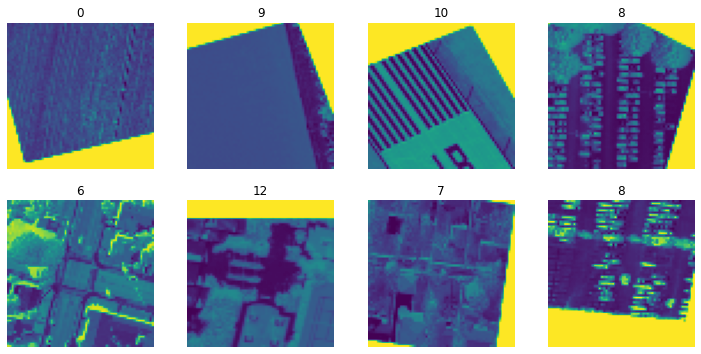

In [3]:
plt.figure(figsize=(10,10))
for i in range(0, 8):
    plt.subplot(440 + 1 + i)
    plt.tight_layout()
    plt.imshow(X[i*100], cmap=plt.get_cmap())
    plt.axis('off')
    plt.title(Y[i*100].argmax())    
plt.show()

In [4]:
X.shape

(31200, 64, 64)

In [5]:
Y.shape

(31200, 13)

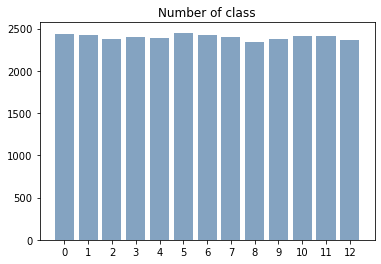

In [6]:
num_class = np.unique(Y.argmax(axis=1), return_counts=True) 
plt.title("Number of class")
plt.xticks(num_class[0])
plt.bar(num_class[0], num_class[1],color = (0.2, 0.4, 0.6, 0.6) )
plt.show()

In [7]:
X_flat = np.array(X).reshape((-1, 64*64))
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.4, random_state=42)

In [8]:
X_flat.shape

(31200, 4096)

In [9]:
#Principle Componenet Analysis (PCA)

In [10]:
from sklearn.decomposition import PCA
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.87) + 1
d

136

In [11]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (31200, 136)
recovered shape: (31200, 4096)


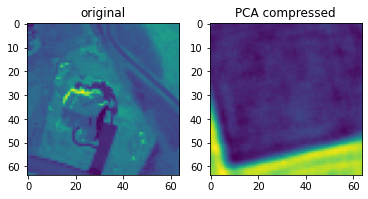

In [13]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

In [14]:
X = X.reshape(-1, 64, 64, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=20)

In [15]:
X_train.shape

(24960, 64, 64, 1)

In [16]:
y_train.shape

(24960, 13)

In [17]:
# Convert Images to Gray scale

In [18]:
X_train = X_train /255
X_test = X_test/255

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Convolution2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Create Model

In [20]:
import keras
from keras import layers,models
from keras.layers import BatchNormalization

from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

In [21]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [22]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(68, (5, 5), input_shape = (64, 64, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(68, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


classifier.add(Conv2D(68, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
#classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(0.5))

classifier.add(Flatten())
classifier.add(BatchNormalization())
classifier.add(Dense(units = 13, activation = 'softmax'))

# Compiling the CNN

classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
from keras.preprocessing.image import ImageDataGenerator

# Generate Images
train_datagen = ImageDataGenerator(
                                   shear_range = 0.08,
                                   zoom_range = 0.08,
                                   horizontal_flip = False,
                                   width_shift_range= 0.02,
                                   height_shift_range= 0.02)
test_datagen = ImageDataGenerator(rescale = 1./255)

# fit parameters from data
training_set = train_datagen.flow(X_train, y_train, batch_size=10)
test_set = test_datagen.flow(X_test, y_test, batch_size=10)

start = time.time() # Measuring the processing time
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 50,
                         epochs =100,
                         validation_data = test_set,
                         validation_steps = 10,
                         verbose=2)
end = time.time()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
50/50 - 5s - loss: 0.2713 - accuracy: 0.0620 - val_loss: 0.2713 - val_accuracy: 0.0600
Epoch 2/100
50/50 - 4s - loss: 0.2711 - accuracy: 0.0840 - val_loss: 0.2711 - val_accuracy: 0.0700
Epoch 3/100
50/50 - 4s - loss: 0.2715 - accuracy: 0.0740 - val_loss: 0.2712 - val_accuracy: 0.0900
Epoch 4/100
50/50 - 4s - loss: 0.2711 - accuracy: 0.0900 - val_loss: 0.2716 - val_accuracy: 0.0300
Epoch 5/100
50/50 - 4s - loss: 0.2714 - accuracy: 0.0840 - val_loss: 0.2711 - val_accuracy: 0.0600
Epoch 6/100
50/50 - 4s - loss: 0.2712 - accuracy: 0.0820 - val_loss: 0.2708 - val_accuracy: 0.0600
Epoch 7/100
50/50 - 4s - loss: 0.2712 - accuracy: 0.0740 - val_loss: 0.2714 - val_accuracy: 0.0200
Epoch 8/100
50/50 - 4s - loss: 0.2702 - accuracy: 0.1020 - val_loss: 0.2712 - val_accuracy: 0.0800
Epoch 9/100
50/50 - 4s - loss: 0.2673 - accuracy: 0.1140 - val_loss: 0.2707 - val_accuracy: 0.0800
Epoch 10/100
50/50 - 4s - loss: 0

Epoch 81/100
50/50 - 4s - loss: 0.2207 - accuracy: 0.3220 - val_loss: 0.6267 - val_accuracy: 0.0500
Epoch 82/100
50/50 - 4s - loss: 0.2170 - accuracy: 0.3440 - val_loss: 0.6061 - val_accuracy: 0.1000
Epoch 83/100
50/50 - 4s - loss: 0.2299 - accuracy: 0.2980 - val_loss: 0.6325 - val_accuracy: 0.0900
Epoch 84/100
50/50 - 4s - loss: 0.2202 - accuracy: 0.3420 - val_loss: 0.6704 - val_accuracy: 0.0600
Epoch 85/100
50/50 - 4s - loss: 0.2288 - accuracy: 0.2900 - val_loss: 0.5733 - val_accuracy: 0.0100
Epoch 86/100
50/50 - 4s - loss: 0.2219 - accuracy: 0.3360 - val_loss: 0.7485 - val_accuracy: 0.0800
Epoch 87/100
50/50 - 4s - loss: 0.2139 - accuracy: 0.3420 - val_loss: 0.7541 - val_accuracy: 0.0900
Epoch 88/100
50/50 - 4s - loss: 0.2242 - accuracy: 0.2900 - val_loss: 0.6957 - val_accuracy: 0.1400
Epoch 89/100
50/50 - 4s - loss: 0.2224 - accuracy: 0.2880 - val_loss: 0.7301 - val_accuracy: 0.1400
Epoch 90/100
50/50 - 4s - loss: 0.2191 - accuracy: 0.3060 - val_loss: 0.7251 - val_accuracy: 0.1000


In [24]:
print(end - start)

448.1200075149536


In [25]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 68)        1768      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 68)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 68)        115668    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 68)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 68)          115668    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 68)          0         
_________________________________________________________________
dense (Dense)                (None, 4, 4, 256)         1

In [26]:
scores = classifier.evaluate(X_test, y_test, verbose=1)
print("{}: {:.2f}%".format(classifier.metrics_names[1], scores[1]*100))

195/195 [==============================] - 11s 54ms/step - loss: 0.2093 - accuracy: 0.3604
accuracy: 36.04%


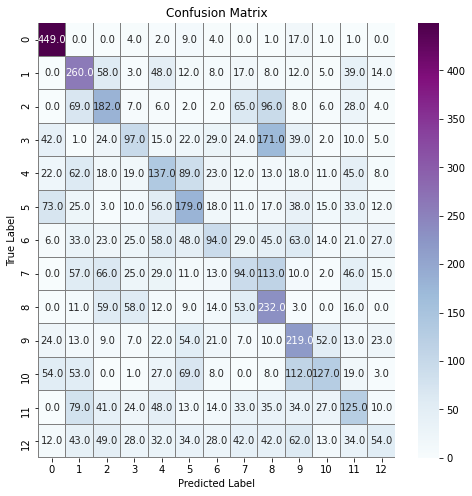

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 
# Predict the values from the validation dataset
Y_pred = classifier.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



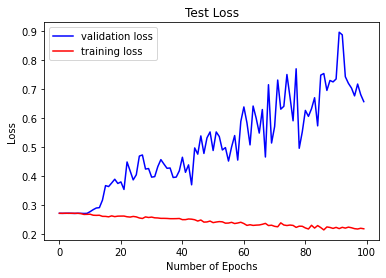

In [28]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="training loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

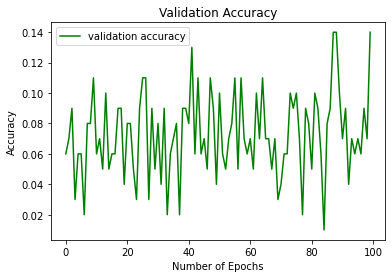

In [29]:
# Plot the accuracy curve for validation 
plt.plot(history.history['val_accuracy'], color='g', label="validation accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [30]:
classifier.save('cnn_weights_2.h5')

In [31]:
classifier.load_weights('cnn_weights_2.h5')

In [32]:
model_feat = Model(inputs=classifier.input,outputs=classifier.get_layer('dense_1').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

(24960, 13)
(6240, 13)


In [33]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
start = time.time() # Measuring the processing time
svm.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()

print('fitting done !!!')

fitting done !!!


In [34]:
print(end - start)

23.29584836959839


In [35]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.42399839743589746

In [36]:
svm.score(feat_test,np.argmax(y_test,axis=1))

0.41875

In [37]:
Pred_labels = svm.predict(feat_test)

# Applying XGBOOST

In [38]:
import xgboost as xgb

xb = xgb.XGBClassifier()
start = time.time() # Measuring the processing time
xb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print('fitting done !!!')

fitting done !!!


In [39]:
print(end - start)

19.59408736228943


In [40]:
xb.score(feat_train,np.argmax(y_train,axis=1))

0.9987980769230769

In [41]:
xb.score(feat_test,np.argmax(y_test,axis=1))

0.9876602564102565

In [42]:
Pred_labels = xb.predict(feat_test)

In [43]:
import seaborn as sns

In [44]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['agriculture','buildings','denseresidential', 'forest', 'freeway', 'golfcourse',
                                       'intersection','mediumresidential','parkinglot','river','runway','sparseresidential',
                                       'tenniscourt'])
    df_cm2.columns=['agriculture','buildings','denseresidential', 'forest', 'freeway', 'golfcourse',
                                       'intersection','mediumresidential','parkinglot','river','runway','sparseresidential',
                                       'tenniscourt']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()

    
    return

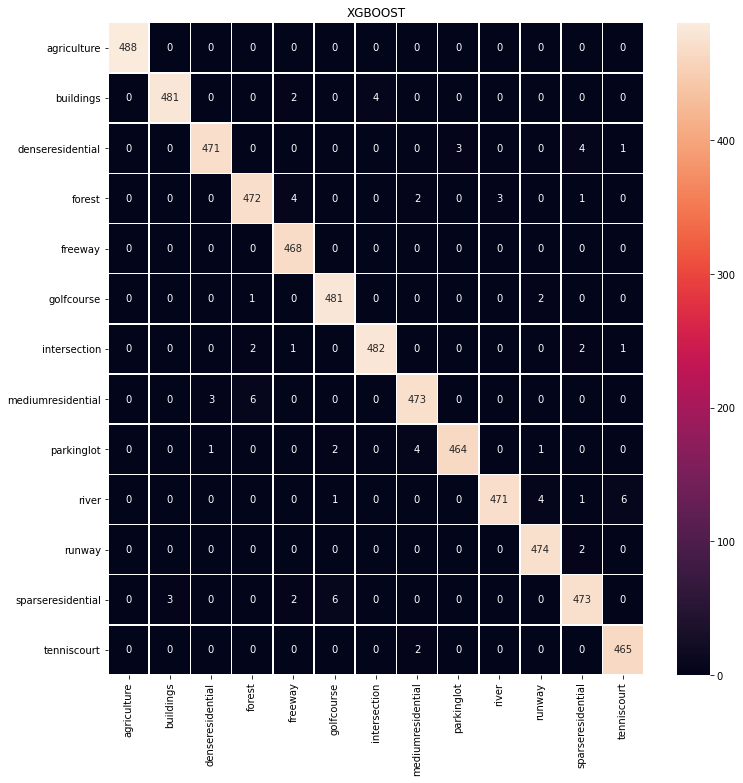

In [45]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'XGBOOST')

In [46]:
from sklearn.metrics import classification_report
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       488
           1     0.9938    0.9877    0.9907       487
           2     0.9916    0.9833    0.9874       479
           3     0.9813    0.9793    0.9803       482
           4     0.9811    1.0000    0.9905       468
           5     0.9816    0.9938    0.9877       484
           6     0.9918    0.9877    0.9897       488
           7     0.9834    0.9813    0.9823       482
           8     0.9936    0.9831    0.9883       472
           9     0.9937    0.9752    0.9843       483
          10     0.9854    0.9958    0.9906       476
          11     0.9793    0.9773    0.9783       484
          12     0.9831    0.9957    0.9894       467

    accuracy                         0.9877      6240
   macro avg     0.9877    0.9877    0.9877      6240
weighted avg     0.9877    0.9877    0.9877      6240



In [47]:
Pred_labels = svm.predict(feat_test)

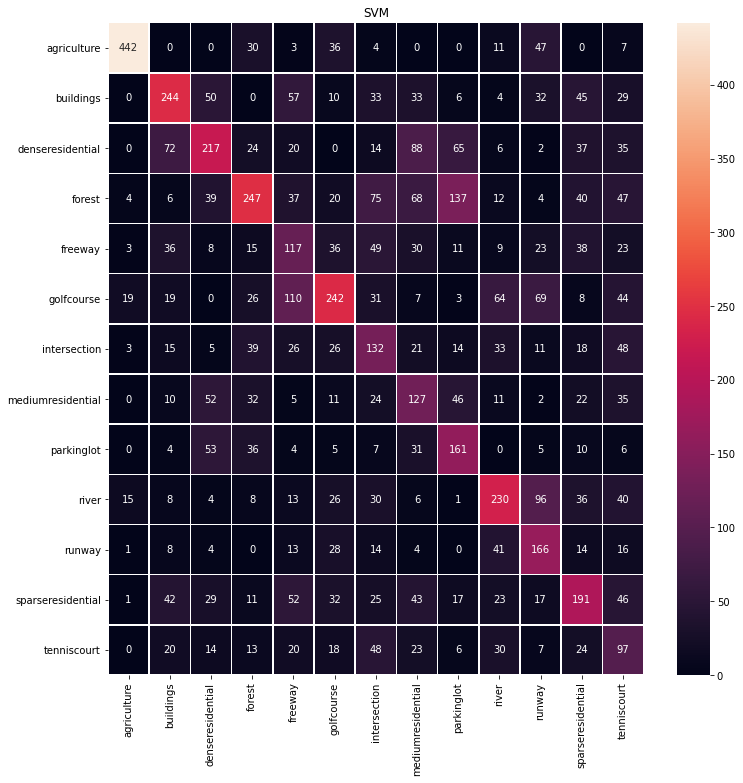

In [48]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'SVM')

In [49]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9057    0.7621    0.8277       580
           1     0.5041    0.4494    0.4752       543
           2     0.4568    0.3741    0.4114       580
           3     0.5135    0.3356    0.4059       736
           4     0.2453    0.2940    0.2674       398
           5     0.4939    0.3769    0.4276       642
           6     0.2716    0.3376    0.3010       391
           7     0.2640    0.3369    0.2960       377
           8     0.3448    0.5000    0.4081       322
           9     0.4852    0.4483    0.4661       513
          10     0.3451    0.5372    0.4203       309
          11     0.3954    0.3611    0.3775       529
          12     0.2051    0.3031    0.2446       320

    accuracy                         0.4188      6240
   macro avg     0.4177    0.4166    0.4099      6240
weighted avg     0.4493    0.4188    0.4269      6240



In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [51]:
lr = LogisticRegression()
start = time.time() # Measuring the processing time
lr.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print('fitting done !!!')

fitting done !!!


In [52]:
print(end - start) # Total 

2.682237386703491


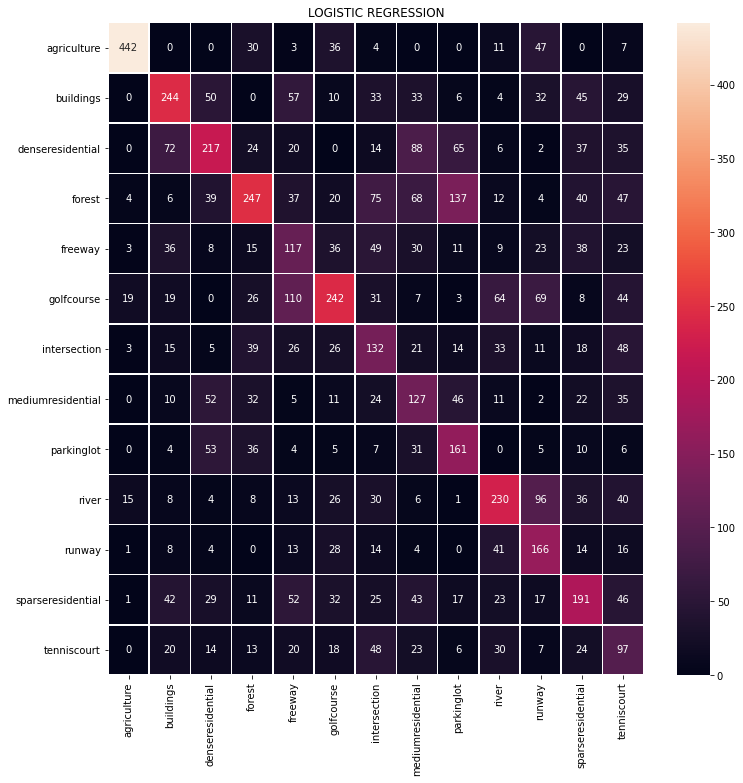

In [53]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LOGISTIC REGRESSION')

In [54]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

              precision    recall  f1-score   support

           0     0.8422    0.7726    0.8059       532
           1     0.4649    0.4269    0.4451       527
           2     0.3368    0.3678    0.3516       435
           3     0.3098    0.2927    0.3010       509
           4     0.2704    0.2627    0.2665       491
           5     0.4184    0.3590    0.3864       571
           6     0.3395    0.2709    0.3014       609
           7     0.2703    0.2434    0.2562       534
           8     0.3555    0.3617    0.3585       459
           9     0.3924    0.4026    0.3974       462
          10     0.3160    0.4620    0.3753       329
          11     0.3230    0.3095    0.3161       504
          12     0.1459    0.2482    0.1838       278

    accuracy                         0.3691      6240
   macro avg     0.3681    0.3677    0.3650      6240
weighted avg     0.3801    0.3691    0.3723      6240



In [55]:
dt = DecisionTreeClassifier()
start = time.time() # Measuring the processing time
dt.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.5315086841583252
fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       488
           1     0.9979    0.9877    0.9928       489
           2     1.0000    0.9979    0.9989       476
           3     0.9875    0.9958    0.9916       477
           4     0.9853    0.9916    0.9884       474
           5     0.9776    0.9938    0.9856       482
           6     1.0000    0.9898    0.9949       491
           7     0.9979    0.9938    0.9959       483
           8     0.9957    0.9894    0.9925       470
           9     0.9937    0.9752    0.9843       483
          10     0.9958    0.9979    0.9969       480
          11     0.9834    0.9834    0.9834       483
          12     0.9810    1.0000    0.9904       464

    accuracy                         0.9920      6240
   macro avg     0.9920    0.9920    0.9920      6240
weighted avg     0.9920    0.9920    0.9920      6240



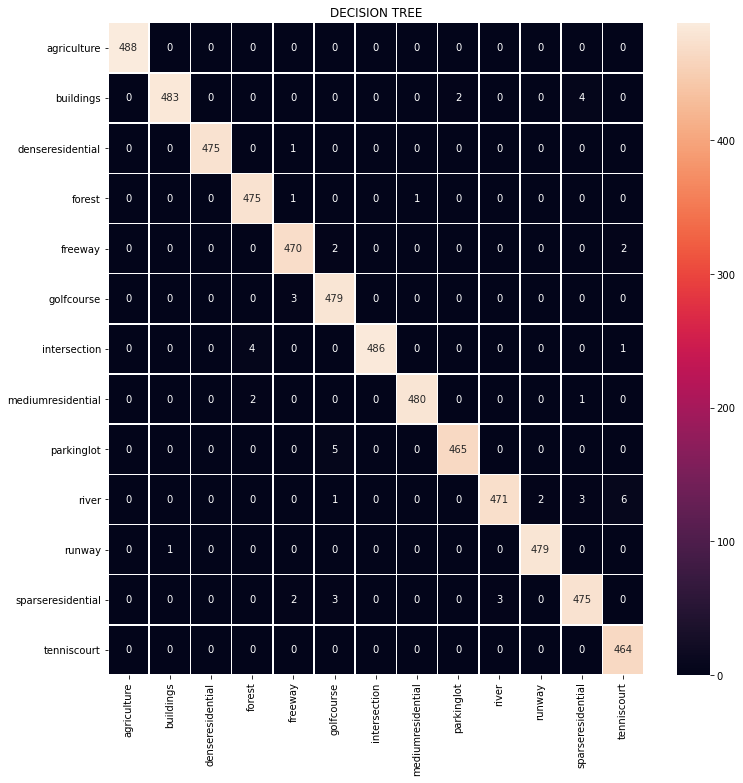

In [56]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'DECISION TREE')

In [57]:
knn = KNeighborsClassifier()
start = time.time() # Measuring the processing time
knn.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.3022642135620117
fitting done !!!
              precision    recall  f1-score   support

           0     0.9611    0.9533    0.9571       492
           1     0.8657    0.7921    0.8272       529
           2     0.7916    0.8139    0.8026       462
           3     0.8233    0.8049    0.8140       492
           4     0.8155    0.7811    0.7979       498
           5     0.8020    0.8581    0.8291       458
           6     0.8436    0.8167    0.8300       502
           7     0.7526    0.8062    0.7785       449
           8     0.7901    0.8039    0.7970       459
           9     0.8228    0.8159    0.8193       478
          10     0.8191    0.8510    0.8347       463
          11     0.8095    0.8012    0.8054       488
          12     0.8118    0.8170    0.8144       470

    accuracy                         0.8240      6240
   macro avg     0.8238    0.8243    0.8236      6240
weighted avg     0.8250    0.8240    0.8242      6240



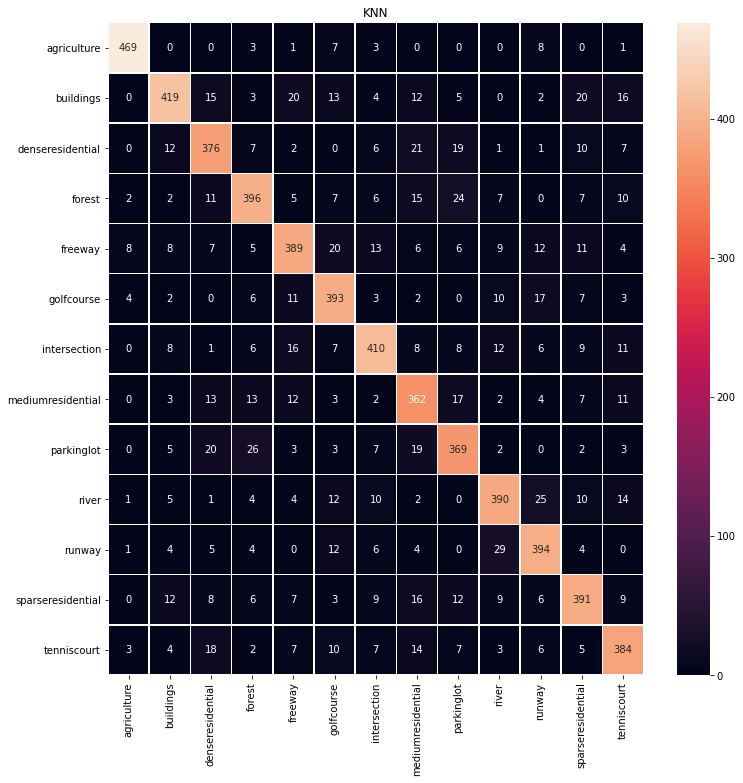

In [58]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'KNN')

In [59]:
lda = LinearDiscriminantAnalysis()
start = time.time() # Measuring the processing time
lda.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.7234206199645996
fitting done !!!
              precision    recall  f1-score   support

           0     0.7951    0.7935    0.7943       489
           1     0.4360    0.4577    0.4466       461
           2     0.3368    0.3960    0.3641       404
           3     0.2973    0.2936    0.2955       487
           4     0.3166    0.2731    0.2932       553
           5     0.4204    0.3428    0.3776       601
           6     0.3436    0.2554    0.2930       654
           7     0.3056    0.2517    0.2761       584
           8     0.3512    0.3628    0.3569       452
           9     0.3586    0.4304    0.3913       395
          10     0.2890    0.4557    0.3537       305
          11     0.3313    0.3162    0.3236       506
          12     0.1776    0.2407    0.2044       349

    accuracy                         0.3670      6240
   macro avg     0.3661    0.3746    0.3669      6240
weighted avg     0.3717    0.3670    0.3663      6240



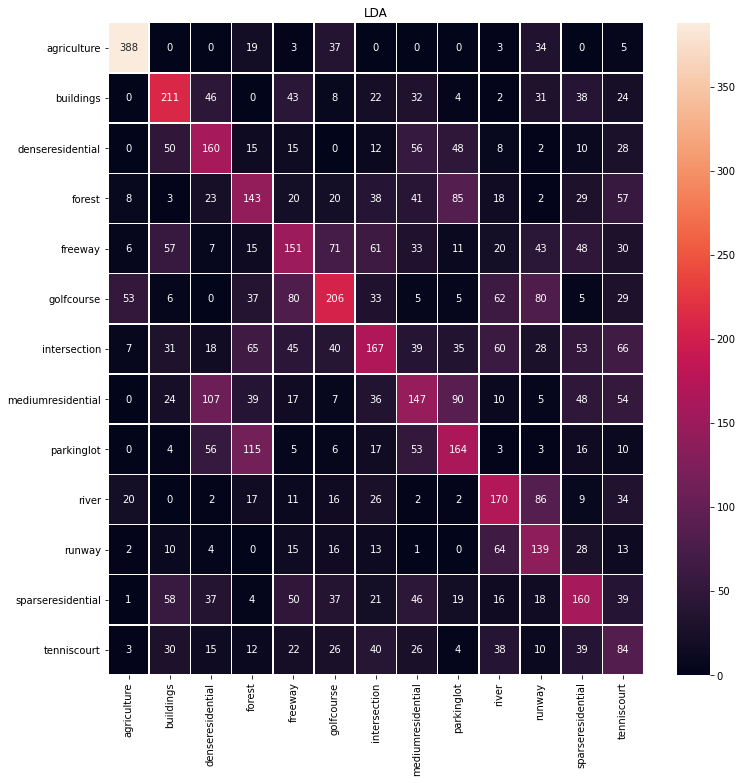

In [60]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LDA')

In [61]:
nb = GaussianNB()
start = time.time() # Measuring the processing time
nb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.009979009628295898
fitting done !!!
              precision    recall  f1-score   support

           0     0.8689    0.6773    0.7612       626
           1     0.4773    0.4103    0.4413       563
           2     0.5242    0.3089    0.3888       806
           3     0.1435    0.2379    0.1790       290
           4     0.1405    0.2454    0.1787       273
           5     0.4571    0.3200    0.3765       700
           6     0.2222    0.2348    0.2283       460
           7     0.2079    0.1934    0.2004       517
           8     0.4732    0.2966    0.3647       745
           9     0.4262    0.3811    0.4024       530
          10     0.2453    0.5592    0.3410       211
          11     0.2422    0.2753    0.2577       425
          12     0.0930    0.4681    0.1552        94

    accuracy                         0.3484      6240
   macro avg     0.3478    0.3545    0.3289      6240
weighted avg     0.4145    0.3484    0.3673      6240



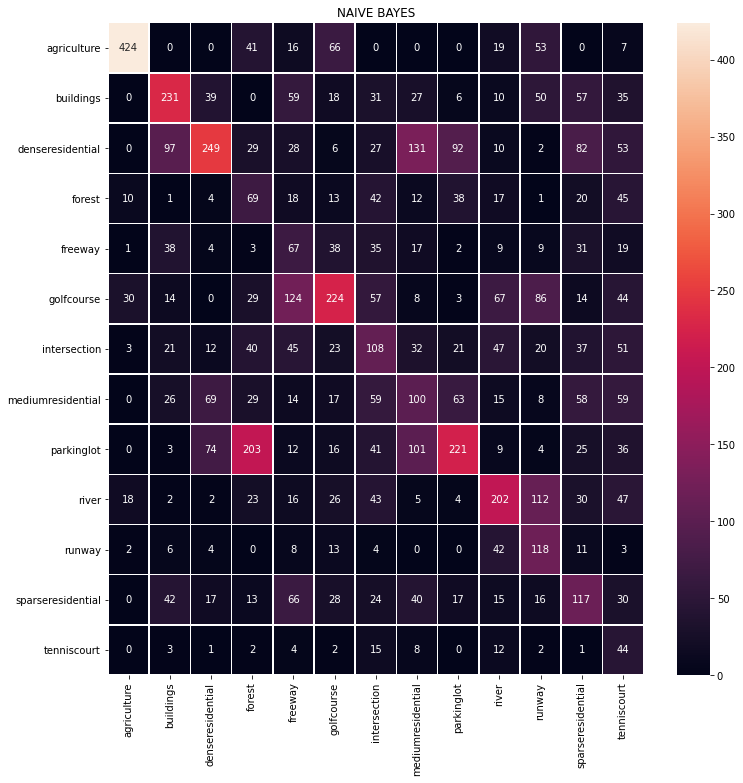

In [62]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'NAIVE BAYES')

In [63]:
et = ExtraTreesClassifier()
start = time.time() # Measuring the processing time
et.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

2.2868845462799072
fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       488
           1     1.0000    0.9878    0.9938       490
           2     1.0000    0.9958    0.9979       477
           3     0.9958    1.0000    0.9979       479
           4     0.9937    1.0000    0.9968       474
           5     0.9816    0.9959    0.9887       483
           6     1.0000    0.9939    0.9969       489
           7     0.9979    0.9836    0.9907       488
           8     0.9957    0.9957    0.9957       467
           9     0.9937    0.9792    0.9864       481
          10     0.9938    0.9979    0.9958       479
          11     0.9855    0.9937    0.9896       479
          12     0.9852    1.0000    0.9925       466

    accuracy                         0.9941      6240
   macro avg     0.9941    0.9941    0.9941      6240
weighted avg     0.9941    0.9941    0.9941      6240



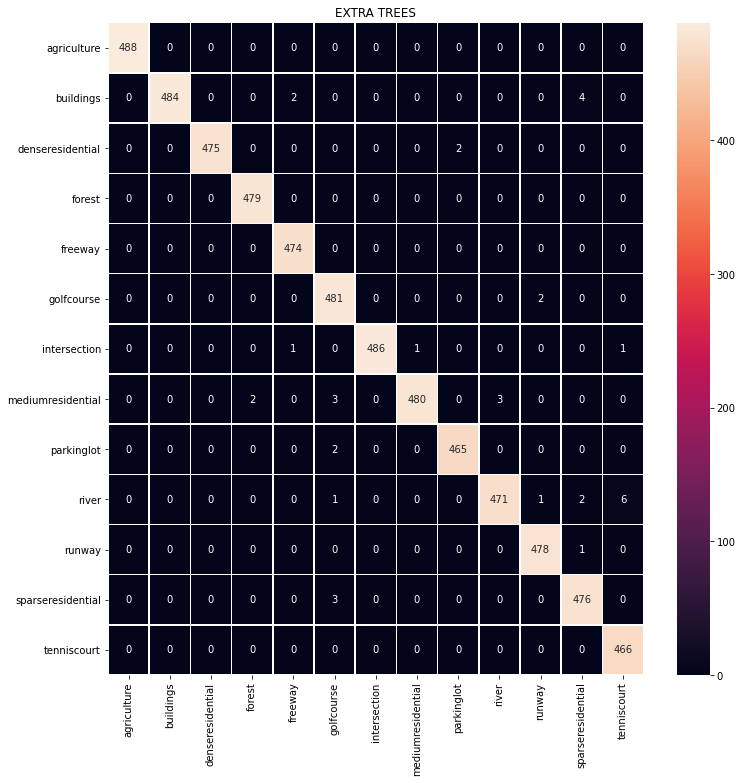

In [64]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'EXTRA TREES')

In [65]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [66]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
start = time.time() # Measuring the processing time
ensemble.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

28.131818532943726
fitting done !!!
              precision    recall  f1-score   support

           0     1.0000    0.9899    0.9949       493
           1     0.9897    0.9561    0.9726       501
           2     0.9853    0.9750    0.9801       480
           3     0.9834    0.9854    0.9844       480
           4     0.9748    0.9979    0.9862       466
           5     0.9796    0.9677    0.9736       496
           6     0.9835    0.9958    0.9896       480
           7     0.9730    0.9936    0.9832       471
           8     0.9936    0.9508    0.9717       488
           9     0.9831    0.9648    0.9739       483
          10     0.9647    0.9872    0.9758       470
          11     0.9669    0.9811    0.9739       476
          12     0.9598    0.9956    0.9774       456

    accuracy                         0.9798      6240
   macro avg     0.9798    0.9801    0.9798      6240
weighted avg     0.9800    0.9798    0.9798      6240



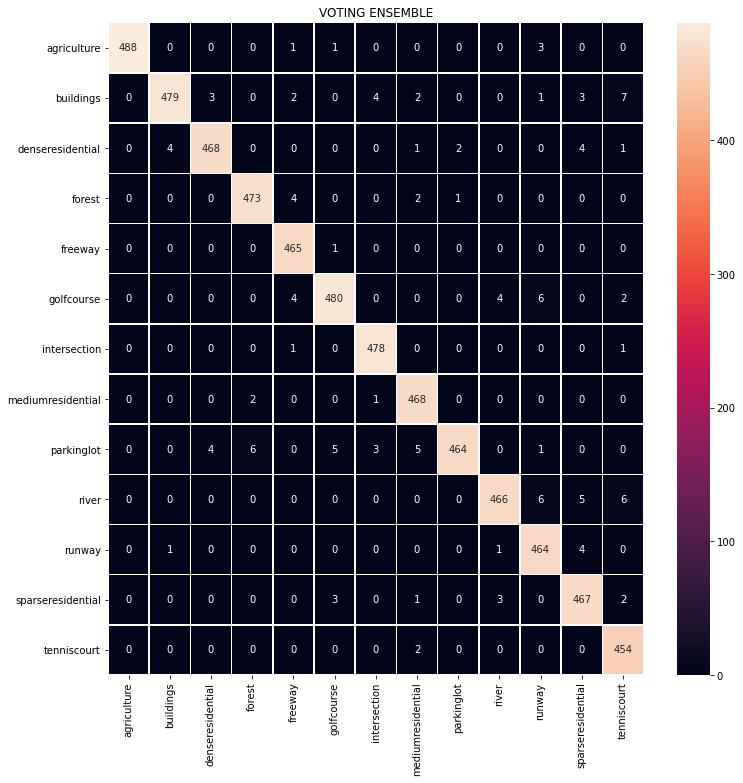

In [67]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'VOTING ENSEMBLE')